## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from surfer import Brain

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [22]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
brainmaps_dir = results_dir + 'brainmaps/'
demograph_file = 'ABIDE_Phenotype.csv'
sm_perf_file = 'atlas_sm_perf.pkl'


### Global Vars

In [4]:
subject_ID_col = 'SubjID'

### Load data

In [6]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# # Results
# with open(results_dir + sm_perf_file, 'rb') as handle:
#     stat_perf_dict = pickle.load(handle)

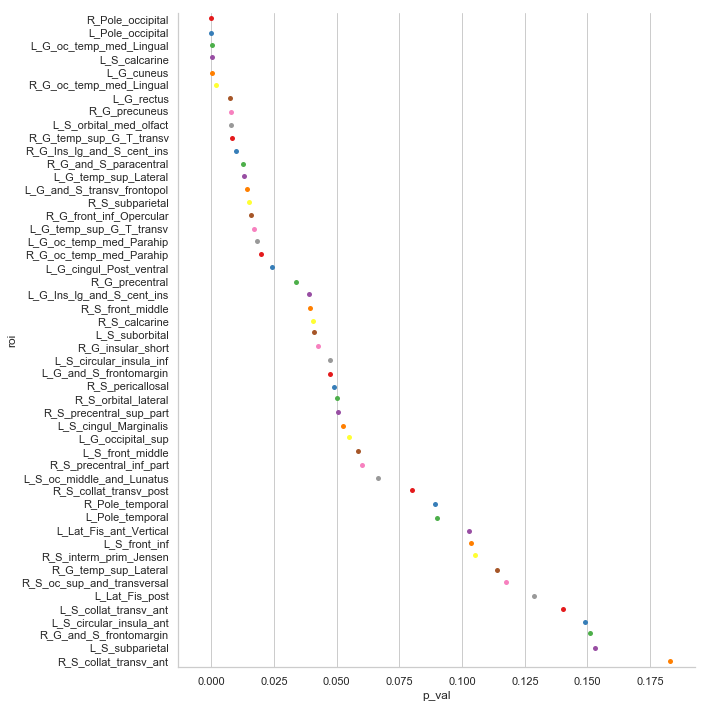

In [46]:
# Plots
aparc = 'Destrieux'
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10)
    #g.set(xscale="log");

## Nilearn based plotting

In [41]:
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()

# The parcellation is already loaded into memory
parcellation = destrieux_atlas['map_left']

# Retrieve fsaverage5 surface dataset for the plotting background. It contains
# the surface template as pial and inflated version and a sulcal depth maps
# which is used for shading
fsaverage = datasets.fetch_surf_fsaverage()

# The fsaverage dataset contains file names pointing to the file locations
print('Fsaverage5 pial surface of left hemisphere is at: %s' %
      fsaverage['pial_left'])
print('Fsaverage5 inflated surface of left hemisphere is at: %s' %
      fsaverage['infl_left'])
print('Fsaverage5 sulcal depth map of left hemisphere is at: %s' %
      fsaverage['sulc_left'])

Fsaverage5 pial surface of left hemisphere is at: /Users/nikhil/anaconda/envs/analytics_pipeline/lib/python3.6/site-packages/nilearn/datasets/data/fsaverage5/pial.left.gii.gz
Fsaverage5 inflated surface of left hemisphere is at: /Users/nikhil/anaconda/envs/analytics_pipeline/lib/python3.6/site-packages/nilearn/datasets/data/fsaverage5/pial_inflated.left.gii.gz
Fsaverage5 sulcal depth map of left hemisphere is at: /Users/nikhil/anaconda/envs/analytics_pipeline/lib/python3.6/site-packages/nilearn/datasets/data/fsaverage5/sulc.left.gii.gz


In [42]:
def get_nilearn_label_format(labels):
    ''' Check label format from freesurfer tables and convert it to nilearn format
        Main differences are 1) prefix of 'L' and 'R' vs format char 'b' 2) '&' char instead of the word 'and'
    '''
    labels_std_L = []
    labels_std_R = []
    for label in labels:
        label_split = label.split('_',1)
        label_std = label_split[1]
        
        if label_split[0] == 'L':
            labels_std_L.append(label_std)
        elif label_split[0] == 'R':
            labels_std_R.append(label_std)
        else:
            print('unknown ROI label {}'.format(label))
            
    return labels_std_L, labels_std_R


In [43]:
p_thresh = 0.05
stat_df = stat_perf_dict['Destrieux']
signific_rois = stat_df[stat_df['p_val'] < p_thresh]['roi'].values
print('Number of signficant ROIs {}'.format(len(signific_rois)))
plot_regions_L,plot_regions_R = get_nilearn_label_format(signific_rois)
print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

Number of signficant ROIs 29
plot regions 
left: ['G_and_S_frontomargin', 'G_and_S_transv_frontopol', 'G_cingul_Post_ventral', 'G_cuneus', 'G_Ins_lg_and_S_cent_ins', 'G_oc_temp_med_Lingual', 'G_oc_temp_med_Parahip', 'G_rectus', 'G_temp_sup_G_T_transv', 'G_temp_sup_Lateral', 'Pole_occipital', 'S_calcarine', 'S_circular_insula_inf', 'S_orbital_med_olfact', 'S_suborbital'], 
right: ['G_and_S_paracentral', 'G_front_inf_Opercular', 'G_Ins_lg_and_S_cent_ins', 'G_insular_short', 'G_oc_temp_med_Lingual', 'G_oc_temp_med_Parahip', 'G_precentral', 'G_precuneus', 'G_temp_sup_G_T_transv', 'Pole_occipital', 'S_calcarine', 'S_front_middle', 'S_pericallosal', 'S_subparietal']


In [44]:
#parcellation.shape
labels = destrieux_atlas['labels']
labels = [l.decode("utf-8").replace('-','_') for l in labels]

# Extract seed region via label
plot_labels_L = []
for roi in plot_regions_L:
    plot_labels_L.append(np.where(parcellation == labels.index(roi))[0])
    
plot_labels_R = []
for roi in plot_regions_R:
    plot_labels_R.append(np.where(parcellation == labels.index(roi))[0])

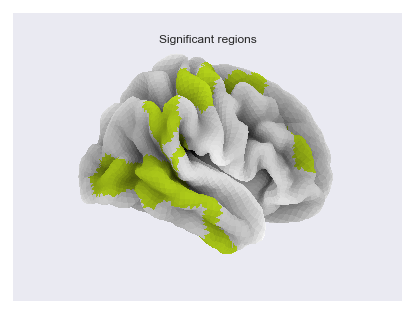

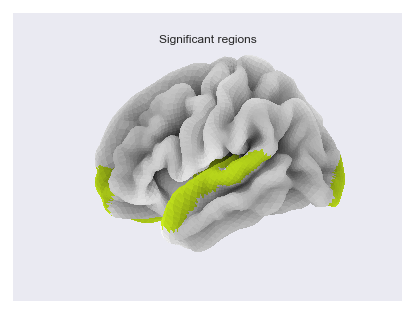

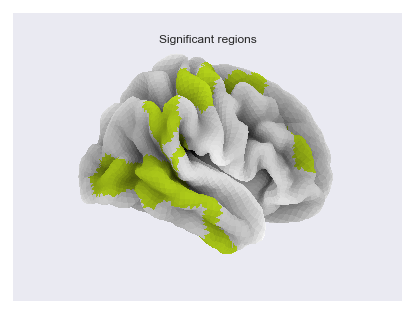

In [45]:

plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=np.hstack(plot_labels_L),
                       hemi='left', view='lateral',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       title='Significant regions')

plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=np.hstack(plot_labels_R),
                       hemi='right', view='lateral',
                       bg_map=fsaverage['sulc_right'], bg_on_data=True,
                       title='Significant regions')

## PySurfer 

In [33]:
import nibabel as nib
import numpy as np
import os
from surfer import Brain
from mayavi import mlab
import time
mlab.init_notebook()
mlab.options.offscreen = True

#%matplotlib inline
%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_test_dir/

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_test_dir/


In [25]:
def create_surface_plot(subject_id,hemi,surf,aparc,signific_rois,save_dir,title,view='lateral',signifcance_color=1):
    """
    Creates a pysurfer brain, overlays surface parcellation, and colormaps given ROIs 
    Used for plotting signficant ROIs
    """
    brain = Brain(subject_id, hemi, surf, background="white",title=title,views=view)


    aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                              subject_id, "label",
                              hemi + aparc)
    labels, ctab, names = nib.freesurfer.read_annot(aparc_file)

    print('number of total vertices {} and ROIs {}'.format(len(labels),len(names)))
    
    # Convert names from bytes to strings
    names = [n.decode("utf-8").replace('-','_') for n in names]
          
    idx = []
    for roi in signific_rois:
        idx.append(names.index(roi))

    roi_value = np.zeros(len(names)) #np.random.randint(5, size=len(names)) #np.zeros(len(names))
    roi_value[idx] = np.arange(2,len(idx)+2) #signifcance_color

    print('number of significant rois {}'.format(len(signific_rois)))
          
    vtx_data = roi_value[labels]
          
    #Handle vertices that are not defined in the annotation.
    vtx_data[labels == -1] = -1
    unique, counts = np.unique(vtx_data, return_counts=True)
    print(dict(zip(unique, counts)))
    
    brain.add_data(vtx_data,colormap="icefire", alpha=.8, colorbar=True)
    save_path = '{}surf{}.png'.format(save_dir,title)
    brain.save_image(save_path)
    print('Image saved at {}'.format(save_path))

In [35]:
subjects_dir = '/home/nikhil/projects/CT_reproduce/data/fs_test_dir/'
subject_id = "fsaverage"
surf = 'inflated' #'white' #"inflated"
aparc = '.aparc.a2009s.annot' #'.aprac.annot', '.aparc.a2009s.annot', '.HCP-MMP1.annot'
views = ['lateral','medial']
save_dir = brainmaps_dir

for hemi in ['lh','rh']:
    if hemi=='lh':
        signific_rois = ['G_and_S_frontomargin', 'G_and_S_transv_frontopol', 'G_cingul_Post_ventral', 'G_cuneus', 
            'G_Ins_lg_and_S_cent_ins', 'G_oc_temp_med_Lingual', 'G_oc_temp_med_Parahip', 'G_rectus', 
            'G_temp_sup_G_T_transv', 'G_temp_sup_Lateral', 'Pole_occipital', 'S_calcarine', 
            'S_circular_insula_inf', 'S_orbital_med_olfact', 'S_suborbital']

    else: 
        signific_rois = ['G_and_S_paracentral', 'G_front_inf_Opercular', 'G_Ins_lg_and_S_cent_ins', 'G_insular_short', 
     'G_oc_temp_med_Lingual', 'G_oc_temp_med_Parahip', 'G_precentral', 'G_precuneus', 'G_temp_sup_G_T_transv', 
     'Pole_occipital', 'S_calcarine', 'S_front_middle', 'S_pericallosal', 'S_subparietal']

    for view in views:
        title = '{}_{}_{}_{}'.format(aparc,surf,hemi,view)
        brain_fig = create_surface_plot(subject_id,hemi,surf,aparc,left,save_dir,title,view)
        time.sleep( 5 )

number of total vertices 163842 and ROIs 76
number of significant rois 15
{0.0: 126941, 2.0: 932, 3.0: 627, 4.0: 520, 5.0: 1430, 6.0: 769, 7.0: 2483, 8.0: 2416, 9.0: 1197, 10.0: 716, 11.0: 2784, 12.0: 2028, 13.0: 3085, 14.0: 2463, 15.0: 822, 16.0: 742, -1.0: 13887}
colormap sequential: [-1.00e+00, 7.50e+00, 1.60e+01] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/surf.aparc.a2009s.annot_inflated_lh_lateral.png
number of total vertices 163842 and ROIs 76
number of significant rois 15
{0.0: 126941, 2.0: 932, 3.0: 627, 4.0: 520, 5.0: 1430, 6.0: 769, 7.0: 2483, 8.0: 2416, 9.0: 1197, 10.0: 716, 11.0: 2784, 12.0: 2028, 13.0: 3085, 14.0: 2463, 15.0: 822, 16.0: 742, -1.0: 13887}
colormap sequential: [-1.00e+00, 7.50e+00, 1.60e+01] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/surf.aparc.a2009s.annot_inflated_lh_medial.png
number of total vertices 163842 and ROIs 76
number of s

In [23]:
brain = Brain(subject_id, hemi, surf, background="white",title=title)


aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi + aparc)
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)

In [ ]:
['G_and_S_frontomargin', Only sulc
 'G_and_S_transv_frontopol', Y
 'G_cingul_Post_ventral', Y
 'G_cuneus', Y
 'G_Ins_lg_and_S_cent_ins', Y
 'G_oc_temp_med_Lingual',  Y
 'G_oc_temp_med_Parahip', Y
 'G_rectus', N
 'G_temp_sup_G_T_transv', Y
 'G_temp_sup_Lateral', Y
 'Pole_occipital', Y
 'S_calcarine', Y
 'S_circular_insula_inf', Y
 'S_orbital_med_olfact', N
 'S_suborbital' N] 